## Model evaluation

### Binary classification: negative or postive

In [1]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [2]:
using Revise
#using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

[ Info: Precompiling TransformersLite [6579f8b0-5af2-4c97-8a45-e81aa57d569b]


In [3]:
include("../../common/reporting.jl")
include("../../common/vocab.jl")
include("../../common/training.jl")

update_history! (generic function with 1 method)

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [4]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [5]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [6]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [7]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [8]:
directory = "outputs/20240212_n1"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => identity
  :indexer   => IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])
  :model     => TransformerClassifier{Embedding{Matrix{Float32}}, PositionEncod…

In [9]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = identity
indexer = IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])


TransformerClassifier(
  Embedding(6996 => 8),                 # 55_968 parameters
  PositionEncoding(8),
  Dropout(0.1),
  TransformerBlock(
    MultiHeadAttention(num_heads=4, head_size=2, 8=>8)(
      denseQ = Dense(8 => 8; bias=false),  # 64 parameters
      denseK = Dense(8 => 8; bias=false),  # 64 parameters
      denseV = Dense(8 => 8; bias=false),  # 64 parameters
      denseO = Dense(8 => 8),           # 72 parameters
    ),
    Dropout(0.1),
    LayerNorm(8),                       # 16 parameters
    Dense(8 => 32, relu),               # 288 parameters
    Dense(32 => 8),                     # 264 parameters
    Dropout(0.1),
    LayerNorm(8),                       # 16 parameters
  ),
  Dense(8 => 1),                        # 9 parameters
  FlattenLayer(),
  Dense(50 => 1),                       # 51 parameters
)        # Total: 18 trainable arrays, 56_876 parameters,
          # plus 1 non-trainable, 8_000 parameters, summarysize 254.992 KiB.

In [10]:
max_sentence_length = size(model.head.weight, 2)

50

## Tokenizers

In [11]:
y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3

@time tokens = map(d->preprocess(d, tokenizer, max_length=max_sentence_length), documents[idxs])
@time indices = indexer(tokens) 

X_train = indices
Y_train = reshape(y_train[idxs], 1, :)
train_data, val_data = split_validation(MersenneTwister(2718), X_train, Y_train)

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  3.511380 seconds (22.41 M allocations: 1.391 GiB, 15.83% gc time, 5.70% compilation time)
  0.263802 seconds (28.27 k allocations: 64.177 MiB, 9.23% gc time, 16.28% compilation time)
train samples:      (50, 144000) (1, 144000)
validation samples: (50, 16000) (1, 16000)


In [12]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3
y_test = reshape(y_test[idxs], 1, :);

@time tokens_test = map(d->preprocess(d, tokenizer, max_length=max_sentence_length), documents_test) 
@time indices_test = indexer(tokens_test)

documents_test_sub = documents_test[idxs]
X_test = indices_test[:, idxs]

println("test documents: ", size(documents_test_sub))
println("test samples: ", size(X_test), " ", size(y_test))

  0.183873 seconds (733.48 k allocations: 46.636 MiB, 13.37% gc time, 35.87% compilation time)
  0.011259 seconds (5 allocations: 1.946 MiB)
test documents: (4000,)
test samples: (50, 4000) (1, 4000)


In [13]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [14]:
loss(ŷ::AbstractMatrix, y::AbstractMatrix) = Flux.logitbinarycrossentropy(ŷ, y)
accuracy(ŷ::AbstractMatrix, y::AbstractMatrix) = mean((Flux.sigmoid.(ŷ) .> 0.5) .== y)

accuracy (generic function with 1 method)

In [15]:
batched_metrics(model, train_data_loader, loss, accuracy)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:29


(loss = 0.2616491f0, accuracy = 0.8913472f0)

In [16]:
batched_metrics(model, val_data_loader, loss, accuracy)

batch metrics... 100%|███████████████████████████████████| Time: 0:00:02


(loss = 0.29403466f0, accuracy = 0.8731875f0)

In [17]:
history = open(joinpath(directory, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 5 entries:
  "train_loss"      => Any[0.41771, 0.35399, 0.312225, 0.298017, 0.286437, 0.28…
  "train_accuracy"  => Any[0.807688, 0.842896, 0.865514, 0.87441, 0.878347, 0.8…
  "mean_batch_loss" => Any[0.582924, 0.408068, 0.36002, 0.337954, 0.324804, 0.3…
  "val_accuracy"    => Any[0.814812, 0.840125, 0.859563, 0.866938, 0.869937, 0.…
  "val_loss"        => Any[0.416325, 0.35888, 0.320575, 0.309367, 0.302714, 0.3…

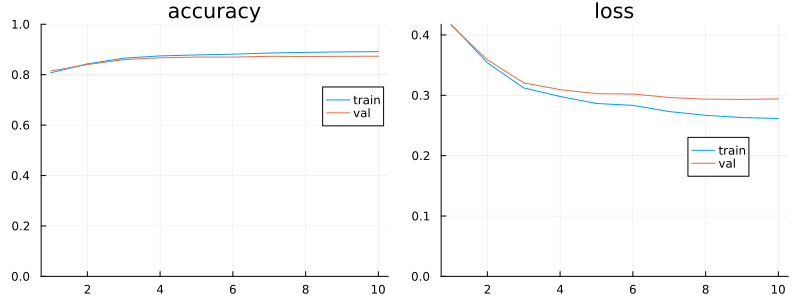

In [18]:
epochs = 1:length(history["train_accuracy"])
p1 = plot(epochs, history["train_accuracy"], label="train")
plot!(p1, epochs, history["val_accuracy"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [19]:
logits = model(X_test)
accuracy(logits, y_test)

0.869

In [20]:
probs = σ.(logits)
y_pred = Int.(probs .> 0.5);

In [21]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1786   214
  310  1690

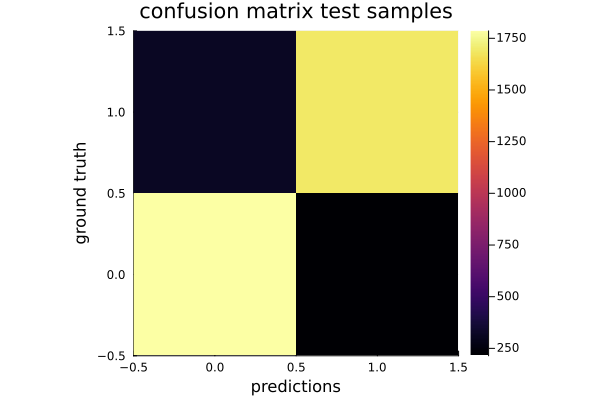

In [22]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [23]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.85    0.89      0.87     2000
           1       0.89    0.84      0.87     2000

weighted avg       0.87    0.87      0.87     4000

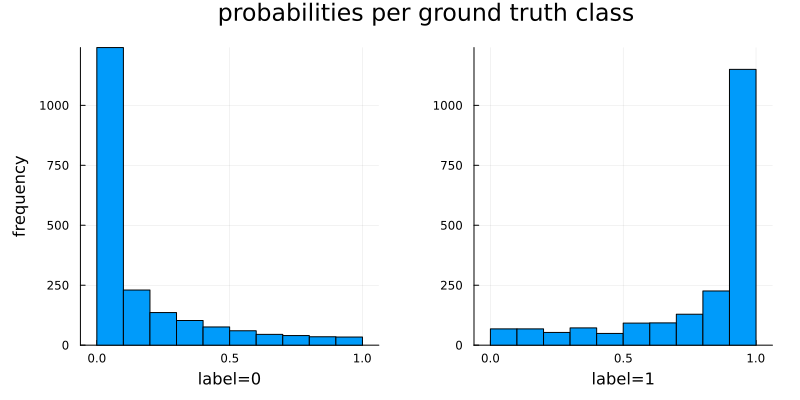

In [24]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [25]:
pos_max = argmax(probs)[2]
pos_min = argmin(probs)[2]

println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
2696  1  1  0.9999  Good product! Perfect size, cute, and easy. Glad I bought this!
1403  0  0  0.0002  I bought this specifically as the product description says it has a board short connector. It does NOT. Very disappointing. Now have to deal with returning it.


In [26]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 2))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, y_test[idx], y_pred[idx], probs[idx], documents_test_sub[idx]
            )
        end
    end
    println("")
end

correct: 1786 / 2000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
1441  0  0  0.0806  On the picture the dress looked like it had flare at the bottom turns out it doesn't. It is just a straight dress that is high in the front and low in the back. Not what I expected
----------------------------------------------------------------------------------------------------
1259  0  0  0.2157  I like the quality but extremely too small. Looks like a 2x.
----------------------------------------------------------------------------------------------------
1172  0  0  0.1679  Does no work with Moto z force 2
----------------------------------------------------------------------------------------------------
1905  0  1  0.6319  This runs small,order a size up and it is “ok “,but not comfortable-Plus it has those tiny little snaps and takes a few minutes to get them attached-I wear it because it does work well for me , but I

## Test data including star=3

In [27]:
probs_all = σ.(model(indices_test));
y_pred_all = Int.(probs_all .> 0.5);

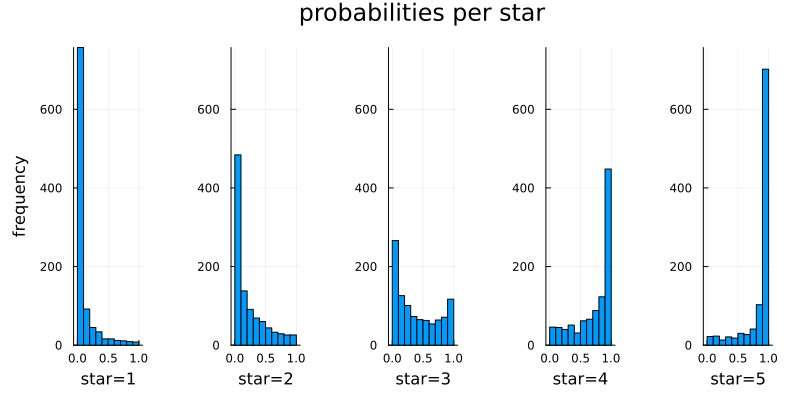

In [28]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [29]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    println("-"^100)
    @printf("%4d  %d  %d  %.4f  %s\n",
    idx, labels_test[idx], y_pred_all[idx], probs_all[idx], documents_test[idx]
    )
end

star = 3
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
2950  3  1  0.5020  It is a nice study case and feels good in the hand, but after installing, it is all bowed out at the top and bottom edges. I tried several times and removed my screen protector and it is still showing gaps at the home button. I think mine may be slightly warped.
----------------------------------------------------------------------------------------------------
2030  3  1  0.7297  These are pretty but only provide minimal shaping.
----------------------------------------------------------------------------------------------------
2782  3  1  0.5262  Good sound and decent battery life for the price, but doesn't charge very well. The cord it came with didn't really work from the beginning. I had to use another cord I had. It loses BT connection randomly and that's when I know it's out of battery life. Even though it shows over half charge 

## Single samples

In [30]:
idx = 4700  

d = documents_test[idx]
println(labels_test[idx])
println(d)
println("")

tokens = preprocess(d, tokenizer, max_length=50)
println(join(tokens, "|"))
println("")

x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.

this|makes|almost|the|whole|series|roman|nights|will|be|the|last|one|loved|them|all|alaskan|nights|was|awesome|met|my|expectations|hot|seal|hero|beautiful|feisty|woman|filled|with|intrigue|steamy|romance|nail|biting|ending|have|read|two|other|books|of|yours|am|looking|forward|to|more

8|231|290|2|448|658|1|2366|45|27|2|164|29|223|38|36|1|2366|14|442|3084|12|1499|438|848|3619|328|1|1757|1329|16|5779|5937|1907|1667|6495|1365|18|186|106|78|577|11|5048|104|162|726|5|57|1


In [31]:
model.embedding(x)

8×50 Matrix{Float32}:
  0.135285   -1.00665     0.63319   …  -0.733241    0.176261   0.0246437
  1.18545     1.00495     0.978864      1.3571      0.993398   0.634116
  0.0638834   1.04747    -0.142737     -0.117856   -0.180146  -0.214177
 -0.192573   -0.298009    0.779278      0.0358208   1.00798   -0.0812582
 -0.278631   -0.601132    0.677123      0.106054    0.727061  -0.661627
 -0.784228   -1.09655    -0.422645  …  -0.344691    0.514196   0.0365562
  0.468904    0.374936   -0.205796      0.235761   -0.246974  -0.198175
 -0.348717    0.0610121   1.8879        0.529096   -1.2296    -0.382884

In [32]:
σ.(model(x))

1×1 Matrix{Float32}:
 0.9831161